| Algorithm                        | Use OHE | Use Scaling      | Use PCA     | Notes                                                                 |
| -------------------------------- | ------- | ---------------- | ----------- | --------------------------------------------------------------------- |
| **Logistic Regression**          | ✅ Yes   | ✅ Yes (Standard) | ✅ Optional  | Sensitive to both scale and categorical encoding                      |
| **Support Vector Machine (SVM)** | ✅ Yes   | ✅ Yes (Standard) | ✅ Sometimes | Needs scale; PCA can help reduce complexity                           |
| **Neural Networks (MLP)**        | ✅ Yes   | ✅ Yes (MinMax)   | ✅ Often     | Scaling + PCA helps convergence and reduces overfitting               |
| **K-Nearest Neighbors (KNN)**    | ✅ Yes   | ✅ Yes (MinMax)   | ✅ Optional  | Distance-based — scale is critical                                    |
| **Naive Bayes**                  | ✅ Yes   | ❌ No             | ⚠️ Rarely   | Assumes feature independence; scale usually irrelevant                |
| **Decision Tree**                | ❌ No    | ❌ No             | ❌ No        | Handles categorical/indexed data natively; splits not scale-sensitive |
| **Random Forest**                | ❌ No    | ❌ No             | ❌ No        | Same as decision tree                                                 |
| **Gradient Boosted Trees**       | ❌ No    | ❌ No             | ❌ No        | Tree-based model; don't use OHE/PCA/Scaling                           |


<h1 style='font-weight:bold'> Tutorial </h1>

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, trim
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator, MulticlassClassificationEvaluator
)
from pyspark.ml.functions import vector_to_array

from sklearn.metrics import roc_curve, auc

In [ ]:
import findspark
findspark.init()

In [2]:
# initialize Spark session
spark = SparkSession.builder.appName("Tutorial").getOrCreate()

In [39]:
# read CSV file into a DataFrame
df = spark.read.csv("Data/WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)
# inferSchema to automatically define all column type (integer, double, or string)

# show the first 10 rows of the DataFrame
df.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [4]:
missing_counts = df.select([
    count(when(col(c).isNull() | (trim(col(c)) == ""), c)).alias(c)
    for c in df.columns
])

missing_df = missing_counts.toPandas().T
missing_df.columns = ["missing_count"]
missing_df = missing_df[missing_df["missing_count"] > 0]
print(missing_df)

              missing_count
TotalCharges             11


**Since the missing values are very small ~0.16% of the total observation, it is safe to remove it without affecting the analysis too much**

In [5]:
# drop rows with null values
df = df.filter(trim(col("TotalCharges")) != "")
df = df.filter(col("TotalCharges").isNotNull())

In [6]:
# Re-check missing values to make sure all missing values are handled
missing_counts = df.select([
    count(when(col(c).isNull() | (trim(col(c)) == ""), c)).alias(c)
    for c in df.columns
])

missing_df = missing_counts.toPandas().T
missing_df.columns = ["missing_count"]
missing_df = missing_df[missing_df["missing_count"] > 0]
print(missing_df)

Empty DataFrame
Columns: [missing_count]
Index: []


In [7]:
# convert TotalCharges to double type
df = df.withColumn("TotalCharges", col("TotalCharges").cast("double"))

In [41]:
# convert SeniorCitizen to categorical string type
df = df.withColumn(
    "SeniorCitizen",
    when(df["SeniorCitizen"] == 1, "Yes").otherwise("No")
)
df.groupBy("SeniorCitizen").count().show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+



<h1 style='font-weight:bold; color:orange'> EDA </h1>

In [8]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [9]:
# Check if the dataset is imbalanced
df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5163|
|  Yes| 1869|
+-----+-----+



In [13]:
# Summary Statistics of Numerical Columns
df.select("tenure", "MonthlyCharges", "TotalCharges").describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+
|  count|              7032|              7032|              7032|
|   mean|32.421786120591584| 64.79820819112632|2283.3004408418697|
| stddev|24.545259709263245|30.085973884049825| 2266.771361883145|
|    min|                 1|             18.25|              18.8|
|    max|                72|            118.75|            8684.8|
+-------+------------------+------------------+------------------+



In [14]:
# Null or Missing Value Detection

# Even if inferSchema=True, some columns may have " " as empty strings.
df.select([count(when(trim(col(c)) == "", c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

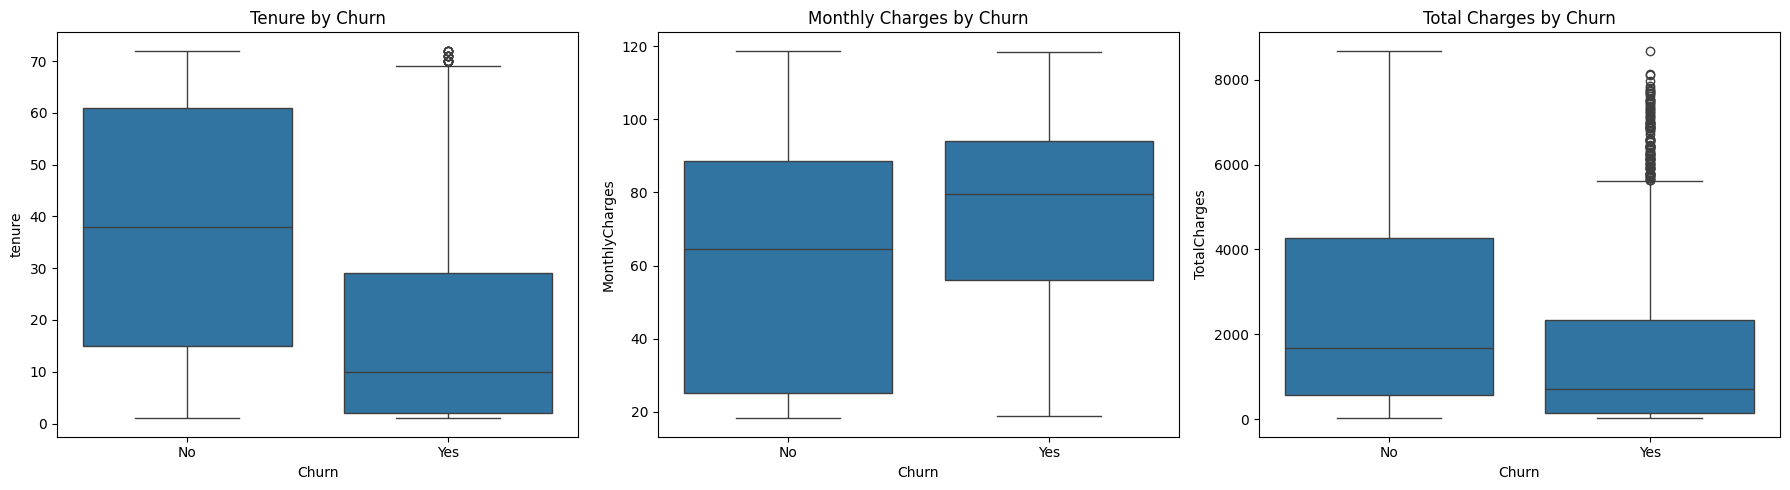

In [15]:
num = df.select("tenure", "MonthlyCharges", "TotalCharges", "Churn").toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Churn', y='tenure', data=num, ax=axes[0])
axes[0].set_title("Tenure by Churn")

sns.boxplot(x='Churn', y='MonthlyCharges', data=num, ax=axes[1])
axes[1].set_title("Monthly Charges by Churn")

sns.boxplot(x='Churn', y='TotalCharges', data=num, ax=axes[2])
axes[2].set_title("Total Charges by Churn")

plt.tight_layout()
plt.show()

Great question! Let’s break it down:

---

### 📊 **What the Boxplots Show (with `hue='Churn'`)**

#### 1. **Tenure by Churn**

* Customers who **did not churn** generally have **longer tenure**.
* Customers who **churned** are skewed toward **shorter tenure**.
* Suggests tenure is **inversely related to churn**.

#### 2. **MonthlyCharges by Churn**

* Churned customers tend to have **higher monthly charges** on average.
* Distributions are wider with some **high outliers**.
* Could suggest pricing sensitivity is a churn factor.

#### 3. **TotalCharges by Churn**

* TotalCharges is naturally higher for **non-churned** customers (they stayed longer).
* Again, **some outliers** at the high end for both groups.

---

### ❓ **Should You Remove Outliers?**

#### 📌 *You MAY remove outliers if:*

* They are **data entry errors** (e.g., TotalCharges = 100000+)
* They **skew model training**, especially for regression or distance-based models (like KNN, KMeans)

#### ❌ *You SHOULD NOT remove outliers if:*

* They are **valid customers** (e.g., premium subscribers)
* You're trying to **predict churn**, where outliers could carry **important signals**

---

### ⚠️ **Implications of Removing Outliers**

| If You Remove Outliers                  | If You Keep Outliers                     |
| --------------------------------------- | ---------------------------------------- |
| May improve model **generalization**    | Model may learn from **real edge cases** |
| May **reduce overfitting**              | Keeps data **distribution realistic**    |
| Can lose **valuable business insights** | May bias model if outliers are noise     |
| Better for models sensitive to scale    | Risk of overemphasis on rare values      |

---

### ✅ Recommendation:

* **Don’t remove outliers yet**
* Instead:

  * **Standardize** or **normalize** features
  * Try models **robust to outliers** (e.g., tree-based methods)
  * Track performance **with and without** outlier filtering

If you want, I can help you filter out outliers using IQR or Z-score method and compare model results.


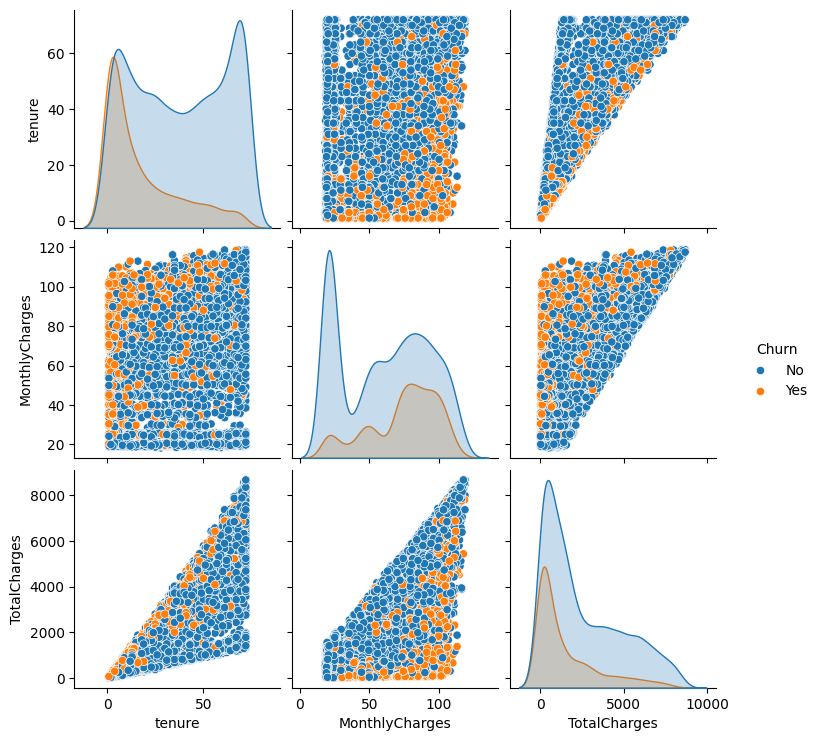

In [16]:
sns.pairplot(num, hue='Churn')
plt.show()

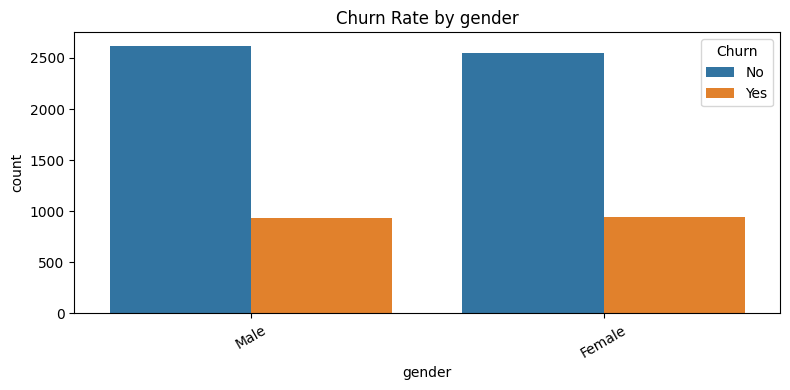

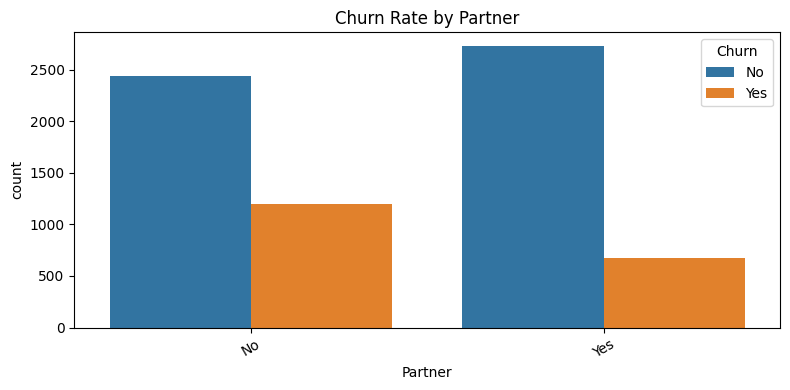

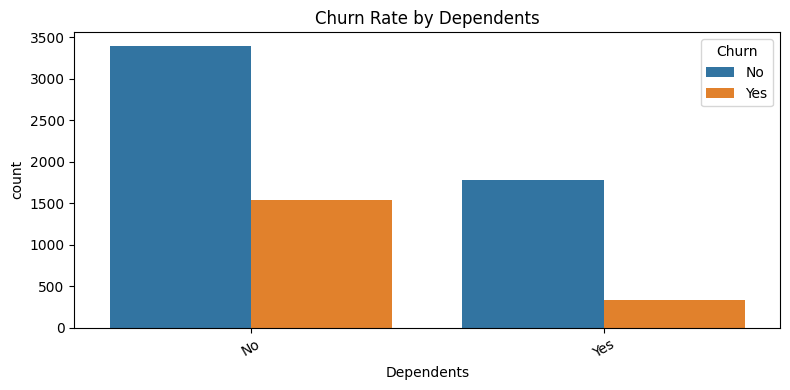

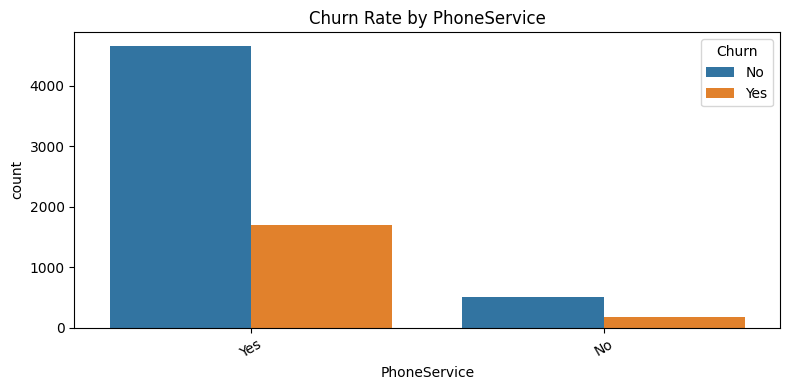

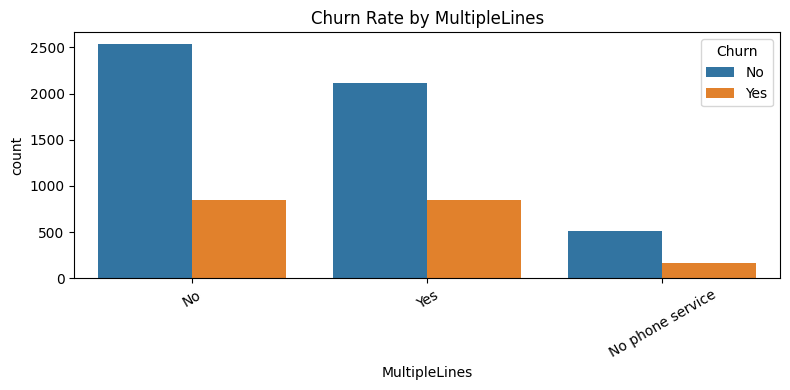

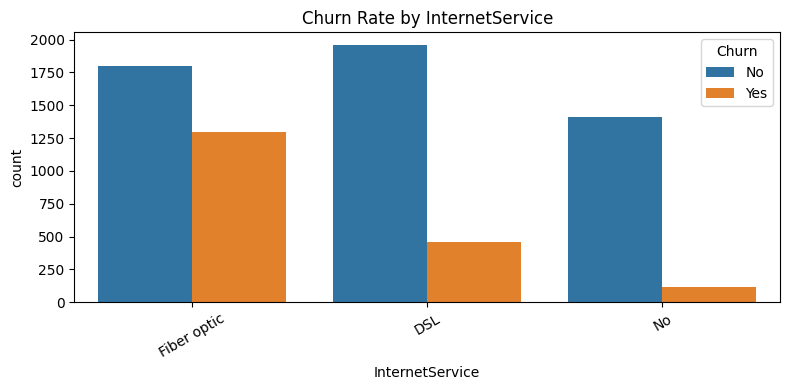

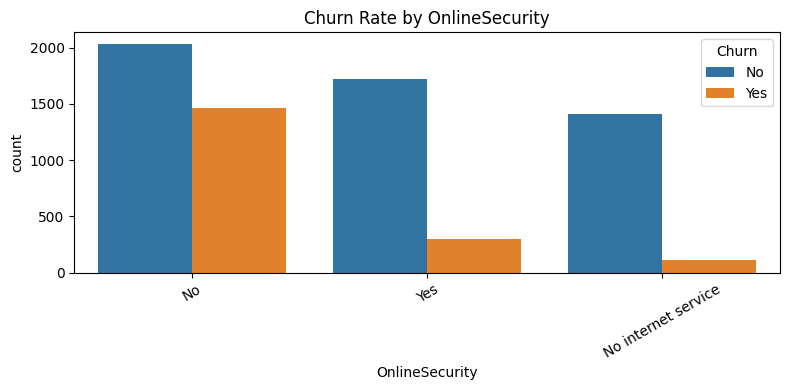

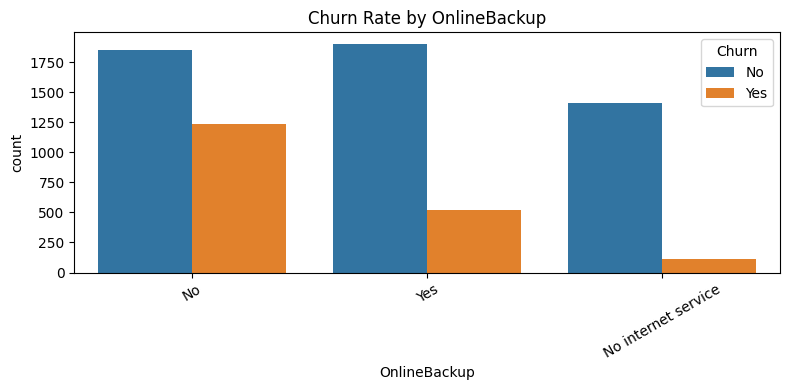

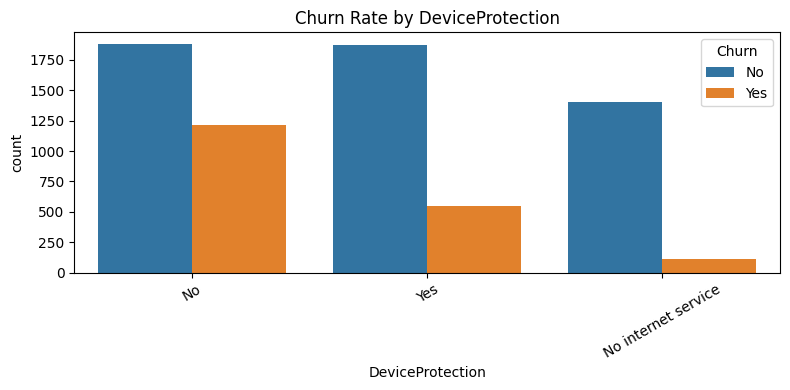

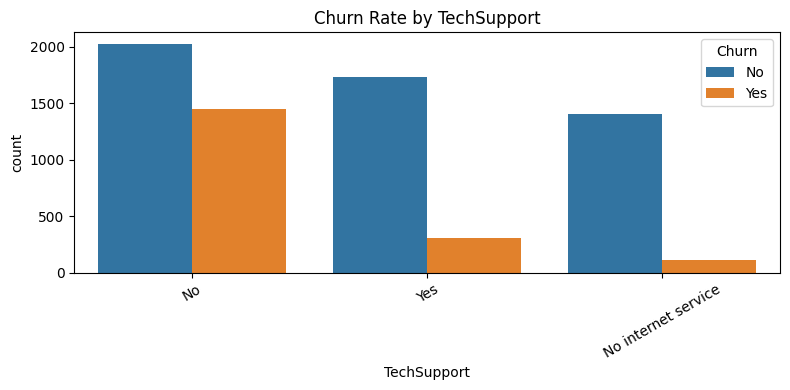

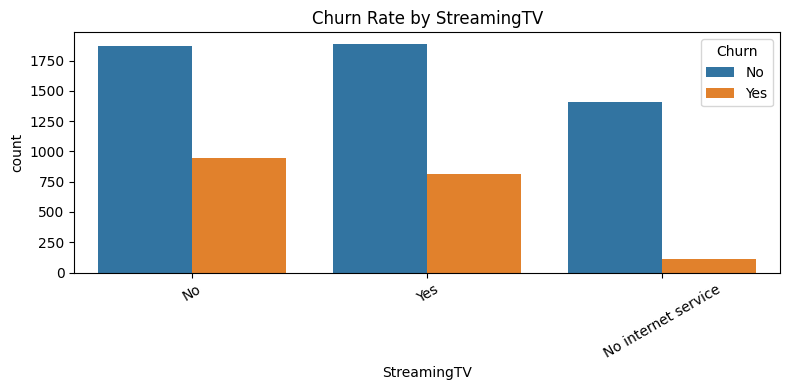

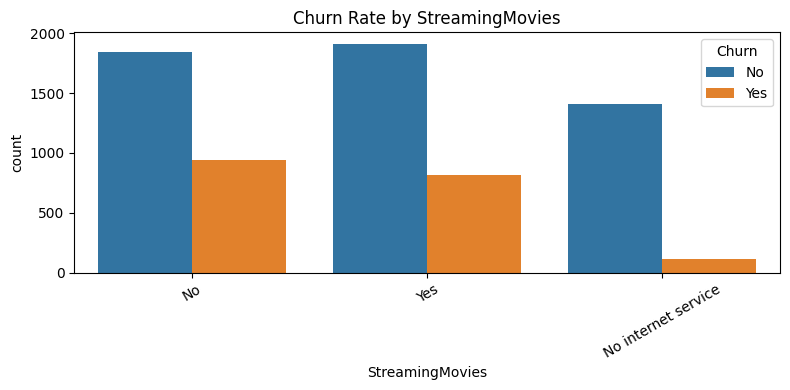

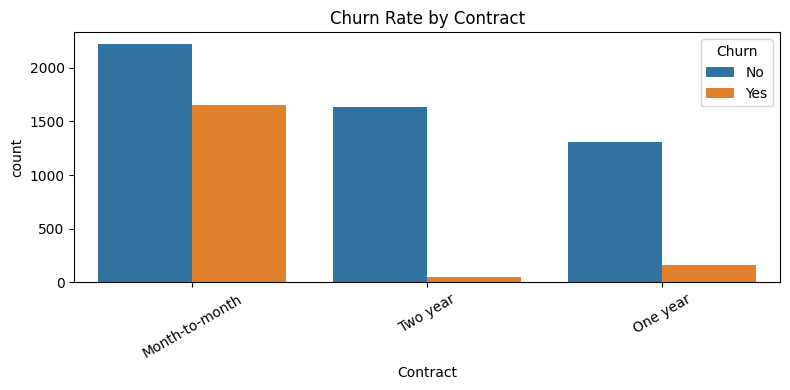

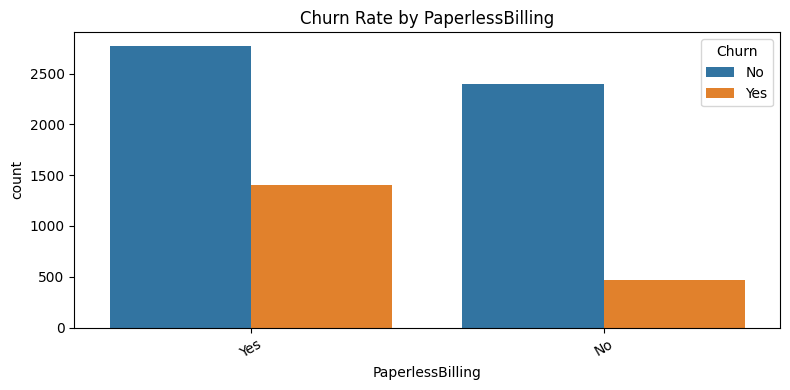

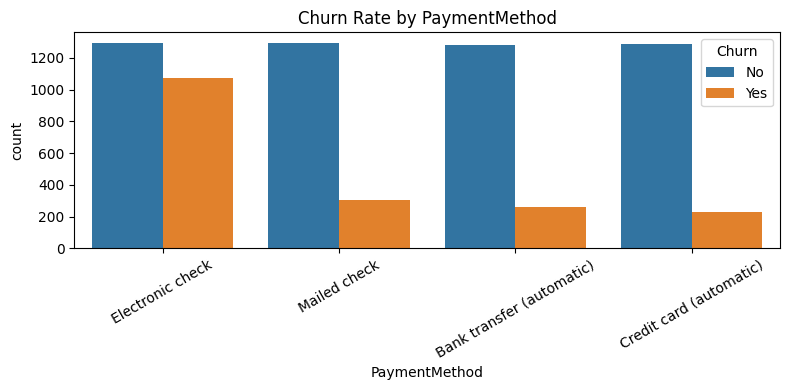

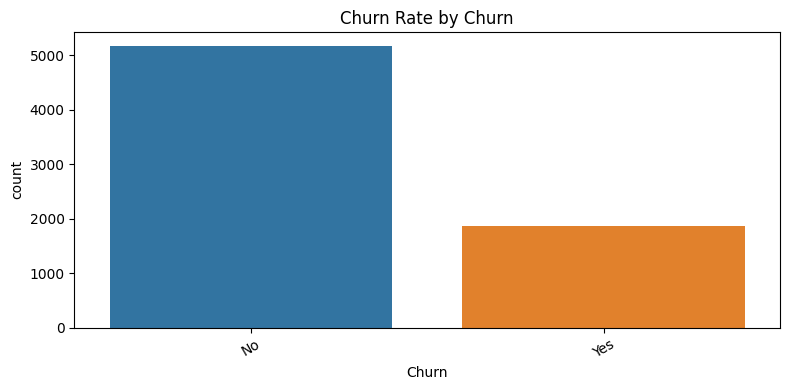

In [17]:
cat_cols = [col for col, dtype in df.dtypes if dtype == "string" and col not in ["customerID"]]

cat_df = df.select(cat_cols).toPandas()

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=cat_df, x=col, hue="Churn", order=cat_df[col].value_counts().index)
    plt.title(f"Churn Rate by {col}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [11]:
num

,tenure,MonthlyCharges,TotalCharges,Churn
0,1,29.85,29.85,No
1,34,56.95,1889.50,No
2,2,53.85,108.15,Yes
3,45,42.30,1840.75,No
4,2,70.70,151.65,Yes
...,...,...,...,...
7027,24,84.80,1990.50,No
7028,72,103.20,7362.90,No
7029,11,29.60,346.45,No
7030,4,74.40,306.60,Yes


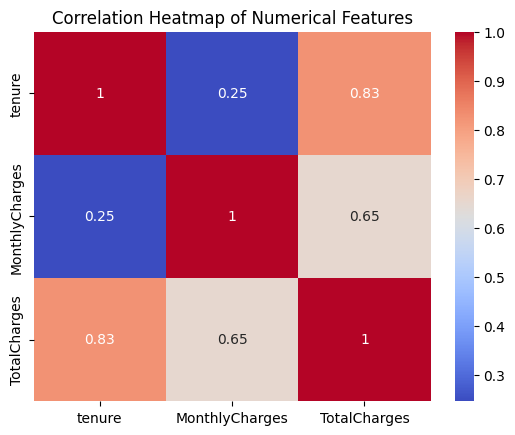

In [18]:
# define numerical only columns 
num_cols = df.select("tenure", "MonthlyCharges", "TotalCharges").toPandas()
sns.heatmap(num_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show();

<h1 style='font-weight:bold; color:orange'> Preprocessing </h1>

<h2 style='font-weight:bold; color:skyblue'> Standardise data </h2>

In [22]:
# Convert Target Column to Label (Yes = 1, No = 0)
label_indexer = StringIndexer(inputCol="Churn", outputCol="label")
df = label_indexer.fit(df).transform(df)
df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|label|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              N

In [31]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [30]:
categorical_cols = [col for col, dtype in df.dtypes if dtype == "string" and col not in ["Churn", "customerID"]]

num_cols = [col for col in df.columns if col not in categorical_cols + ["Churn", "customerID", "label"]]

numeric_cols = [col for col, dtype in df.dtypes if dtype in ("int", "double", "float") and col not in ["Churn", "customerID", "label"]]


In [34]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed") for col in categorical_cols]
df = indexers.fit(df).transform(df)
df.show(5)

AttributeError: 'list' object has no attribute 'fit'

In [40]:
df.groupBy("SeniorCitizen").count().show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|            1| 1142|
|            0| 5901|
+-------------+-----+



In [43]:
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_label")
    data = indexer.fit(data).transform(data)
data.show(10)

NameError: name 'data' is not defined

In [42]:
# Handle Categorical Features
categorical_cols = [col for col, dtype in df.dtypes if dtype == "string" and col not in ["Churn", "customerID"]]

indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed") for col in categorical_cols]

encoders = [OneHotEncoder(inputCol=col+"_indexed", outputCol=col+"_encoded") for col in categorical_cols]

pipeline = Pipeline(stages=indexers + encoders)
model = pipeline.fit(df)
df_transformed = model.transform(df)

# Show only the encoded columns
encoded_cols = [col+"_encoded" for col in categorical_cols]
df_transformed.select(encoded_cols).show(truncate=False)

+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+--------------------+
|gender_encoded|SeniorCitizen_encoded|Partner_encoded|Dependents_encoded|PhoneService_encoded|MultipleLines_encoded|InternetService_encoded|OnlineSecurity_encoded|OnlineBackup_encoded|DeviceProtection_encoded|TechSupport_encoded|StreamingTV_encoded|StreamingMovies_encoded|Contract_encoded|PaperlessBilling_encoded|PaymentMethod_encoded|TotalCharges_encoded|
+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+---------

In [44]:
# Assemble Features and Normalize
numerical_cols = [col for col, dtype in df.dtypes if dtype in ["int", "double"] and col != "label"]

encoded_cols = [col+"_encoded" for col in categorical_cols]

assembler = VectorAssembler(inputCols=numerical_cols + encoded_cols, outputCol="features_assembled")

scaler = StandardScaler(inputCol="features_assembled", outputCol="features", withStd=True, withMean=True)

In [46]:
df1 = assembler.transform(df)
df1.show(5)

IllegalArgumentException: gender_encoded does not exist. Available: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn

<h2 style='font-weight:bold; color:skyblue'> Dimension reduction (PCA) </h2>

In [15]:
# PCA + KMeans for Dimensionality Reduction
pca_model = PCA(k=3, inputCol="features", outputCol="pca_features").fit(df)

explained_variance = pca_model.explainedVariance.toArray()
print(f"Explained Variance by PCA: {explained_variance}")

IllegalArgumentException: features does not exist. Available: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn, label

In [ ]:
# Plot Scree Plot
components = np.arange(1, len(explained_variance)+1)

plt.figure(figsize=(8,5))
plt.plot(components, explained_variance, marker='o')
plt.xticks(components)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(k=2, featuresCol="features", predictionCol="cluster")

<h1 style='font-weight:bold; color:orange'> Training model </h1>

<h2 style='font-weight:bold; color:skyblue'> Logistic regression </h2>

In [ ]:
# Pipeline + Cross Validation
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
df = pipeline.fit(df).transform(df)

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

BinaryClassificationEvaluator_b98cf21c8425

In [ ]:
# Classification Models
lr = LogisticRegression(featuresCol="features", labelCol="label")
pred_lr = lr.transform(test_data)

evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator_acc.evaluate(pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

Logistic Regression Accuracy: 0.7599


<h2 style='font-weight:bold; color:skyblue'> Decision tree </h2>

In [ ]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

pred_dt = dt.transform(test_data)
accuracy_dt = evaluator_acc.evaluate(pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")

Decision Tree Accuracy: 0.7881


<h1 style='font-weight:bold; color:orange'> Tuning parameter </h1>

In [54]:
# Cross Validation
param_grid = ParamGridBuilder().build()

cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

lr_model = cv_lr.fit(train_data)

IllegalArgumentException: label does not exist. Available: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn, customerID_indexed, gender_indexed, Partner_indexed, Dependents_indexed, PhoneService_indexed, MultipleLines_indexed, InternetService_indexed, OnlineSecurity_indexed, OnlineBackup_indexed, DeviceProtection_indexed, TechSupport_indexed, StreamingTV_indexed, StreamingMovies_indexed, Contract_indexed, PaperlessBilling_indexed, PaymentMethod_indexed, TotalCharges_indexed, customerID_encoded, gender_encoded, Partner_encoded, Dependents_encoded, PhoneService_encoded, MultipleLines_encoded, InternetService_encoded, OnlineSecurity_encoded, OnlineBackup_encoded, DeviceProtection_encoded, TechSupport_encoded, StreamingTV_encoded, StreamingMovies_encoded, Contract_encoded, PaperlessBilling_encoded, PaymentMethod_encoded, TotalCharges_encoded, features_assembled, features, CrossValidator_02052ab6e470_rand

In [ ]:
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

dt_model = cv_dt.fit(train_data)

<h1 style='font-weight:bold; color:orange'> Model evaluation </h1>

<h2 style='font-weight:bold; color:skyblue'> Classification report and confusion matrix </h2>

<h2 style='font-weight:bold; color:skyblue'> AUC ROC Curve </h2>

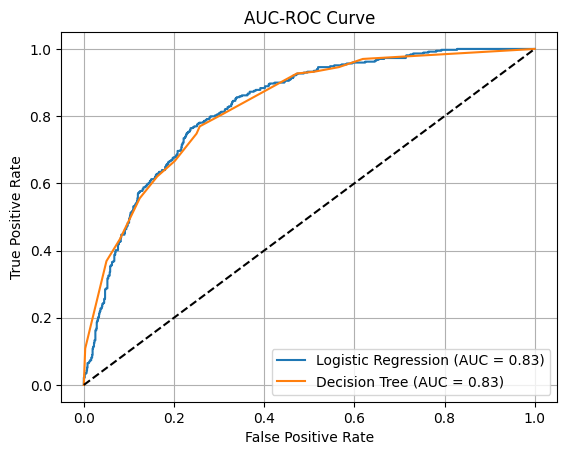

In [30]:
# Plot AUC-ROC Curve
for model, name in zip([lr_model, dt_model], ['Logistic Regression', 'Decision Tree']):
    pred = model.transform(test_data)
    pred = pred.select("label", "probability").withColumn("prob_1", vector_to_array("probability")[1])
    pdf = pred.select("label", "prob_1").toPandas()

    fpr, tpr, _ = roc_curve(pdf['label'], pdf['prob_1'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [56]:
# Stop Spark session
spark.stop()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

Part B: Baseline Model Without Resampling  
1. Train a logistic regression and decision tree model without addressing imbalance. 
2. Report accuracy, precision, recall, F1-score, and AUC. 
3. Discuss why the accuracy might be misleading. <br>
   
Part C: Addressing Imbalance  <br>
Apply at least 3 different methods to handle imbalance such as: <br>
* Random undersampling / oversampling
* SMOTE or ADASYN 
* Class-weight adjustment 
* Cost-sensitive learning 
* Threshold moving 
* Balance bagging